In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import fourier_shift
from scipy.signal import fftconvolve
from skimage.registration import phase_cross_correlation
from scipy.spatial import cKDTree

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.psf import EPSFBuilder, extract_stars
from photutils.psf.matching import create_matching_kernel, TukeyWindow

from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from astropy.table import Table
from astropy.io import fits

%matplotlib widget

In [2]:

# -------------------------
# Helper utilities
# -------------------------

def estimate_translation(ref_image, tgt_image, upsample_factor=80):
    shift, _, _ = phase_cross_correlation(ref_image, tgt_image, upsample_factor=upsample_factor)
    dy, dx = shift
    return float(dy), float(dx)

def apply_fourier_shift(image, dy, dx):
    return np.fft.ifftn(fourier_shift(np.fft.fftn(image), shift=(dy, dx))).real

def detect_stars_daofind(image, fwhm=3.0, n_sigma=5.0, max_stars=5000):
    mean, med, std = sigma_clipped_stats(image, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=n_sigma * std)
    sources = daofind(image - med)
    if sources is None or len(sources) == 0:
        return np.zeros((0,2)), np.zeros((0,))
    sources.sort('flux')
    sources = sources[::-1][:max_stars]
    xy = np.vstack([sources['xcentroid'], sources['ycentroid']]).T
    flux = sources['flux'].data
    return xy, flux

def aperture_fluxes(image, positions, r=4.0):
    """Return numpy array of aperture sums at given positions. Safe: returns zero-length array if no positions."""
    if positions is None or len(positions) == 0:
        return np.zeros((0,))
    ap = CircularAperture(positions, r=r)
    phot = aperture_photometry(image, ap)
    return np.asarray(phot['aperture_sum'])

def match_by_nn_with_mag_cut(pos_ref, flux_ref, pos_tgt, flux_tgt,
                             max_dist=3.0, max_mag_diff=1.5, N_brightest=400):
    """Nearest-neighbor match using brightest-N from reference and a magnitude (flux) consistency cut.
    Returns matched_ref_positions, matched_tgt_positions, per-star flux ratios (ref/tgt).
    All inputs are numpy arrays (pos: Nx2, flux: N).
    """
    if len(pos_ref) == 0 or len(pos_tgt) == 0:
        return np.zeros((0,2)), np.zeros((0,2)), np.array([])
    idx_bright = np.argsort(flux_ref)[::-1][:N_brightest]
    p_ref = pos_ref[idx_bright]
    f_ref = flux_ref[idx_bright]
    # Protect against zeros:
    mags_ref = -2.5 * np.log10(np.clip(f_ref, 1e-12, None))
    mags_tgt = -2.5 * np.log10(np.clip(flux_tgt, 1e-12, None))

    tree = cKDTree(p_ref)
    dist, idx = tree.query(pos_tgt, distance_upper_bound=max_dist)
    good_mask = (dist != np.inf)
    if not np.any(good_mask):
        return np.zeros((0,2)), np.zeros((0,2)), np.array([])

    pos_tgt_m = pos_tgt[good_mask]
    idx_ref = idx[good_mask]
    magdiff = np.abs(mags_ref[idx_ref] - mags_tgt[good_mask])
    keep = magdiff <= max_mag_diff
    if not np.any(keep):
        return np.zeros((0,2)), np.zeros((0,2)), np.array([])

    matched_ref = p_ref[idx_ref[keep]]
    matched_tgt = pos_tgt_m[keep]
    # flux ratio ref / tgt using provided flux arrays (must align indices accordingly)
    flux_ref_kept = f_ref[idx_ref[keep]]
    # For flux_tgt we need fluxes for pos_tgt[good_mask][keep] — upstream must provide flux_tgt array aligned with pos_tgt
    flux_tgt_kept = flux_tgt[good_mask][keep]
    ratio = flux_ref_kept / np.clip(flux_tgt_kept, 1e-12, None)
    return matched_ref, matched_tgt, ratio

def filter_positions_inside(image_shape, positions, box_size):
    """Keep only positions that can support a full box_size cutout."""
    if positions is None or len(positions) == 0:
        return positions
    half = box_size // 2
    ny, nx = image_shape
    keep_mask = (
        (positions[:, 0] >= half) &
        (positions[:, 0] < nx - half) &
        (positions[:, 1] >= half) &
        (positions[:, 1] < ny - half)
    )
    return positions[keep_mask]

def quality_filter_saturation(image, positions, sat_level=None, cut_radius=6):
    """Drop stars whose peak within a small box exceeds saturation."""
    if sat_level is None or positions is None or len(positions) == 0:
        return positions
    keep = np.ones(len(positions), dtype=bool)
    for i,(x,y) in enumerate(positions.astype(int)):
        y0,y1 = max(0,y-cut_radius), min(image.shape[0], y+cut_radius+1)
        x0,x1 = max(0,x-cut_radius), min(image.shape[1], x+cut_radius+1)
        if np.nanmax(image[y0:y1, x0:x1]) >= sat_level:
            keep[i] = False
    return positions[keep]

# EPSF builder wrapper with safe returns
def build_local_epsf(image, positions, box_size=25, nstars_max=120, oversampling=1, min_stars=8):
    if positions is None or len(positions) == 0:
        return None
    positions = filter_positions_inside(image.shape, positions, box_size)
    if len(positions) < min_stars:
        return None
    if len(positions) > nstars_max:
        positions = positions[:nstars_max]
    stars_tbl = Table()
    stars_tbl['x'] = positions[:,0]
    stars_tbl['y'] = positions[:,1]
    nd = NDData(image)
    size = int(box_size)
    stars = extract_stars(nd, stars_tbl, size=size)
    if len(stars) < min_stars:
        return None
    epsf_builder = EPSFBuilder(oversampling=oversampling, maxiters=3, progress_bar=False)
    try:
        epsf, _ = epsf_builder(stars)
    except Exception:
        return None
    if epsf is None or epsf.data is None:
        return None
    arr = np.array(epsf.data, dtype=float)
    s = np.sum(arr)
    if s <= 0 or not np.isfinite(s):
        return None
    return arr / s

def make_tiles(h, w, nrows=3, ncols=3, overlap=16):
    ys = np.linspace(0, h, nrows+1, dtype=int)
    xs = np.linspace(0, w, ncols+1, dtype=int)
    tiles = []
    for i in range(nrows):
        for j in range(ncols):
            y0, y1 = ys[i], ys[i+1]
            x0, x1 = xs[j], xs[j+1]
            y0e = max(0, y0 - overlap); y1e = min(h, y1 + overlap)
            x0e = max(0, x0 - overlap); x1e = min(w, x1 + overlap)
            tiles.append(((y0,y1,x0,x1), (y0e,y1e,x0e,x1e)))
    return tiles

def cosine_weights(shape, core_slice, ext_slice):
    (y0,y1,x0,x1) = core_slice
    (Y0,Y1,X0,X1) = ext_slice
    h, w = Y1-Y0, X1-X0
    wy = np.ones(h); wx = np.ones(w)
    top = y0 - Y0; bot = Y1 - y1
    left = x0 - X0; right = X1 - x1
    if top > 0:
        t = np.linspace(0, np.pi/2, top); wy[:top] = np.sin(t)
    if bot > 0:
        t = np.linspace(0, np.pi/2, bot); wy[-bot:] = np.sin(t[::-1])
    if left > 0:
        t = np.linspace(0, np.pi/2, left); wx[:left] = np.sin(t)
    if right > 0:
        t = np.linspace(0, np.pi/2, right); wx[-right:] = np.sin(t[::-1])
    return np.outer(wy, wx)

def local_kernel_from_epsf(epsf_src, epsf_tgt, window='tukey', beta=0.7):
    if epsf_src is None or epsf_tgt is None:
        return None
    epsf_src = epsf_src / max(np.sum(epsf_src), 1e-12)
    epsf_tgt = epsf_tgt / max(np.sum(epsf_tgt), 1e-12)
    if window == 'tukey':
        win = TukeyWindow(beta)
    # else:
    #     win = HanningWindow()
    K = create_matching_kernel(epsf_src, epsf_tgt, window=win)
    K = np.array(K, dtype=float)
    K /= max(np.sum(K), 1e-12)
    lo, hi = np.percentile(K, 0.1), np.percentile(K, 99.9)
    K = np.clip(K, lo, hi)
    K /= max(np.sum(K), 1e-12)
    return K

def convolve_tile(img, kernel):
    return fftconvolve(img, kernel, mode='same')

# -------------------------
# Main mini_hotpants
# -------------------------

def mini_hotpants(images,
                  fwhm_guess=3.0, n_sigma=5.0,
                  N_brightest=800, max_dist=2.0, max_mag_diff=1.0,
                  grid=(5,5), overlap=48,
                  epsf_box=41, epsf_max_stars=250, epsf_min_stars=8, oversampling=1,
                  window='tukey', beta=0.6,
                  upsample=120,
                  per_tile_photometry=True, per_tile_background=True,
                  sat_level=None,
                  return_intermediates=False):
    """
    Robust mini-HOTPANTS:
      - Fourier subpixel alignment (no warp)
      - Magnitude-gated matches
      - Spatially varying kernels via tiling (fallback to global or identity)
      - Optional per-tile photometric scale & background match

    Returns:
      psf_matched_full, diffs, meta
    """
    assert len(images) >= 2, "Need at least two images"
    H, W = images[0].shape
    nrows, ncols = grid

    # 0) initial detection (positions only) on raw images, filter saturated/in-bounds
    star_cats = []
    proxies = []
    for im in images:
        pos, flux_det = detect_stars_daofind(im, fwhm=fwhm_guess, n_sigma=n_sigma)
        pos = quality_filter_saturation(im, pos, sat_level=sat_level)
        # store only positions; photometry will be done on aligned images
        star_cats.append(pos)
        proxy = np.median(1.0/np.sqrt(np.clip(flux_det[:len(pos)], 1, None))) if len(pos) else np.inf
        proxies.append(proxy)

    ref_idx = int(np.argmin(proxies))
    ref = images[ref_idx].astype(float)

    # 1) Align by Fourier shift
    aligned = []
    shifts = []
    for i, im in enumerate(images):
        if i == ref_idx:
            aligned.append(ref.copy()); shifts.append((0.0,0.0)); continue
        dy, dx = estimate_translation(ref, im, upsample_factor=upsample)
        aligned.append(apply_fourier_shift(im, dy, dx))
        shifts.append((dy, dx))
    aligned = [a.astype(float) for a in aligned]

    # 2) Compute aperture photometry on aligned images (to use for scaling & matching)
    aligned_flux_cats = []
    for i, im in enumerate(aligned):
        pos_i = star_cats[i]
        # ensure positions are inside image bounds
        pos_i = filter_positions_inside(im.shape, pos_i, box_size=epsf_box)
        aligned_flux_cats.append(aperture_fluxes(im, pos_i, r=4.0))

        # update the positions stored to the filtered set (so indices align)
        star_cats[i] = pos_i

    # 3) Photometric scaling from matched stars (global)
    pos_ref = star_cats[ref_idx]
    flux_ref = aligned_flux_cats[ref_idx]
    matches = []
    scales = []
    for i, im in enumerate(aligned):
        if i == ref_idx:
            matches.append((pos_ref, pos_ref, np.ones(len(pos_ref))))
            scales.append(1.0)
            continue
        pos_i = star_cats[i]
        flux_i = aligned_flux_cats[i]
        if len(pos_ref)==0 or len(pos_i)==0 or len(flux_i)==0:
            matches.append((np.zeros((0,2)), np.zeros((0,2)), np.array([])))
            scales.append(1.0)
            continue
        mref, mtgt, scalers = match_by_nn_with_mag_cut(
            pos_ref, flux_ref, pos_i, flux_i,
            max_dist=max_dist, max_mag_diff=max_mag_diff, N_brightest=N_brightest
        )
        if len(scalers) == 0:
            phot_scale = 1.0
        else:
            good = np.isfinite(scalers) & (scalers > 0)
            phot_scale = 1.0 if not np.any(good) else np.median(scalers[good])
        scales.append(phot_scale)
        matches.append((mref, mtgt, scalers))

    aligned_scaled = [im * scales[i] for i, im in enumerate(aligned)]

    # 4) Global EPSFs (fallback if a tile is star-poor)
    global_epsf = []
    for i, im in enumerate(aligned_scaled):
        pos_i = star_cats[i]
        epsf_i = build_local_epsf(im, pos_i, box_size=epsf_box,
                                  nstars_max=epsf_max_stars,
                                  oversampling=oversampling,
                                  min_stars=epsf_min_stars)
        global_epsf.append(epsf_i)

    # 5) Tiles & local EPSFs
    tiles = make_tiles(H, W, nrows=nrows, ncols=ncols, overlap=overlap)
    epsfs_per_img_per_tile = [[None for _ in tiles] for _ in images]

    for t_idx, (core, ext) in enumerate(tiles):
        (y0,y1,x0,x1), (Y0,Y1,X0,X1) = core, ext
        # reference tile EPSF
        posR = star_cats[ref_idx]
        if len(posR):
            maskR = (posR[:,0] >= X0) & (posR[:,0] < X1) & (posR[:,1] >= Y0) & (posR[:,1] < Y1)
            posR_loc = (posR[maskR] - np.array([X0, Y0]))
            epsf_ref = build_local_epsf(aligned_scaled[ref_idx][Y0:Y1, X0:X1], posR_loc,
                                        box_size=epsf_box, nstars_max=epsf_max_stars,
                                        oversampling=oversampling, min_stars=epsf_min_stars)
        else:
            epsf_ref = None
        if epsf_ref is None:
            epsf_ref = global_epsf[ref_idx]  # fallback
        epsfs_per_img_per_tile[ref_idx][t_idx] = epsf_ref

        # others
        for i in range(len(images)):
            if i == ref_idx:
                continue
            posI = star_cats[i]
            if len(posI):
                maskI = (posI[:,0] >= X0) & (posI[:,0] < X1) & (posI[:,1] >= Y0) & (posI[:,1] < Y1)
                posI_loc = (posI[maskI] - np.array([X0, Y0]))
                epsf_i = build_local_epsf(aligned_scaled[i][Y0:Y1, X0:X1], posI_loc,
                                          box_size=epsf_box, nstars_max=epsf_max_stars,
                                          oversampling=oversampling, min_stars=epsf_min_stars)
            else:
                epsf_i = None
            if epsf_i is None:
                epsf_i = global_epsf[i]
            epsfs_per_img_per_tile[i][t_idx] = epsf_i

    # 6) Per-tile processing: optional photometric scale & background, then kernel & convolve
    psf_matched = [aligned_scaled[ref_idx].copy()]
    for i in range(len(images)):
        if i == ref_idx:
            continue
        out = np.zeros_like(aligned_scaled[i])
        wsum = np.zeros_like(aligned_scaled[i])
        for t_idx, (core, ext) in enumerate(tiles):
            (y0,y1,x0,x1), (Y0,Y1,X0,X1) = core, ext
            tile_ref = aligned_scaled[ref_idx][Y0:Y1, X0:X1]
            tile_img = aligned_scaled[i][Y0:Y1, X0:X1]

            # per-tile photometric scale (robust median on matched stars in ext)
            if per_tile_photometry:
                mref, mtgt, _ = matches[i]
                if len(mref) and len(mtgt):
                    in_ref = (mref[:,0] >= X0) & (mref[:,0] < X1) & (mref[:,1] >= Y0) & (mref[:,1] < Y1)
                    in_tgt = (mtgt[:,0] >= X0) & (mtgt[:,0] < X1) & (mtgt[:,1] >= Y0) & (mtgt[:,1] < Y1)
                    idx = in_ref & in_tgt
                    if np.any(idx):
                        fr = aperture_fluxes(aligned_scaled[ref_idx], mref[idx], r=4.0)
                        fi = aperture_fluxes(aligned_scaled[i],     mtgt[idx], r=4.0)
                        good = (fi>0) & np.isfinite(fr/fi)
                        if np.any(good):
                            s_tile = np.median(fr[good]/fi[good])
                            tile_img = tile_img * s_tile

            # per-tile background offset (on unmasked pixels)
            if per_tile_background:
                diff = tile_img - tile_ref
                med = np.nanmedian(diff)
                sig = 1.4826*np.nanmedian(np.abs(diff - med))
                keep = np.abs(diff - med) < 3*sig
                if np.any(keep):
                    bkg = np.nanmedian(diff[keep])
                    tile_img = tile_img - bkg

            # kernels
            epsf_src = epsfs_per_img_per_tile[i][t_idx]
            epsf_tgt = epsfs_per_img_per_tile[ref_idx][t_idx]
            if epsf_src is None or epsf_tgt is None:
                tile_conv = tile_img  # identity
            else:
                K = local_kernel_from_epsf(epsf_src, epsf_tgt, window=window, beta=beta)
                tile_conv = convolve_tile(tile_img, K)

            W = cosine_weights(aligned_scaled[i].shape, (y0,y1,x0,x1), (Y0,Y1,X0,X1))
            out[Y0:Y1, X0:X1] += tile_conv * W
            wsum[Y0:Y1, X0:X1] += W

        img_conv = aligned_scaled[i].copy()
        mask = wsum > 0
        img_conv[mask] = out[mask] / wsum[mask]
        psf_matched.append(img_conv)

    # Reassemble in original order
    psf_matched_full = [None]*len(images)
    psf_matched_full[ref_idx] = psf_matched[0]
    j = 1
    for i in range(len(images)):
        if i == ref_idx: continue
        psf_matched_full[i] = psf_matched[j]; j += 1

    # Differences against reference
    diffs = []
    for i in range(len(images)):
        if i == ref_idx:
            continue
        diffs.append(psf_matched_full[i] - psf_matched_full[ref_idx])

    meta = dict(ref_index=ref_idx, shifts=shifts, phot_scales=scales, tiles=tiles)
    if return_intermediates:
        return aligned_scaled, psf_matched_full, diffs, meta
    return psf_matched_full, diffs, meta


In [3]:
files = ['i', 'r', 'g']
f_files = []

for f in files:
    file = f'/Users/zgl12/Python_Scripts/Image_Processing/ygp/2023ygp-0011_{f}_wcs.fits.gz'

    hdu = fits.open(file)
    image_data = hdu[0].data -500
    hdu.close()

    f_files.append(image_data)

In [4]:
psf_matched_imgs, diff_imgs, meta = mini_hotpants(
    images=f_files,              # list of 2D arrays
    fwhm_guess=3.0,
    n_sigma=5.0,
    N_brightest=1000,
    max_dist=2.0,
    max_mag_diff=1.0,
    grid=(5,5),
    overlap=48,
    epsf_box=41,
    epsf_max_stars=250,
    epsf_min_stars=8,
    oversampling=1,
    window='tukey',              # try 'hanning' if halos persist
    beta=0.7,
    upsample=120,
    per_tile_photometry=True,
    per_tile_background=True,
    sat_level=45000,              # set to your detector’s saturation (e.g. 55000)
    return_intermediates=False
)

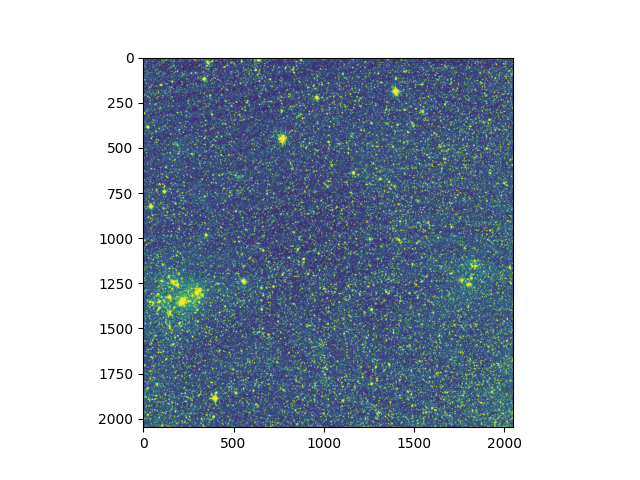

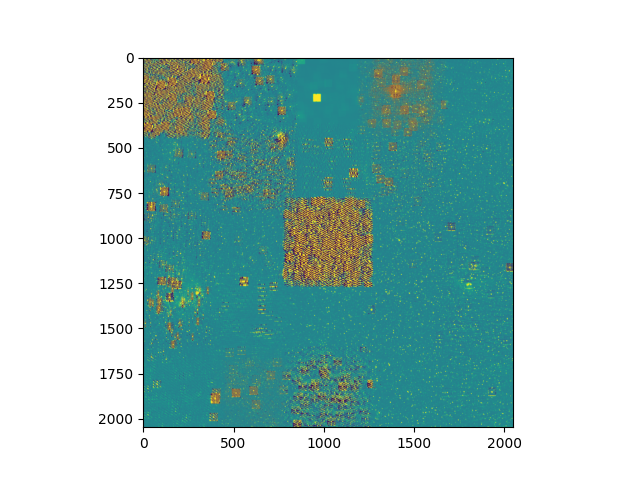

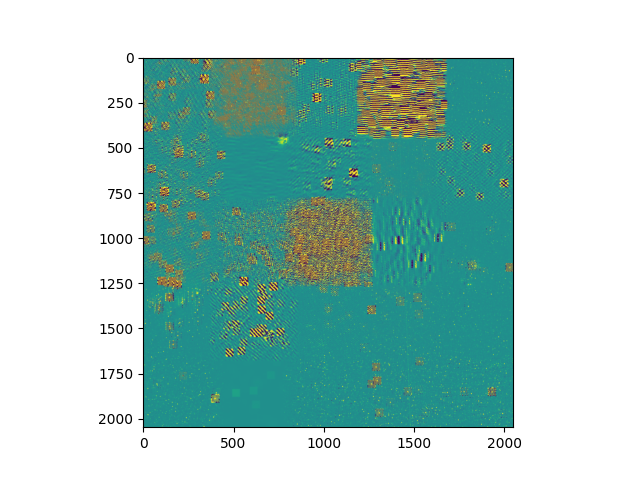

In [5]:
for i in range(len(psf_matched_imgs)):

    data = psf_matched_imgs[i]
    plt.figure()
    plt.imshow(data, vmin = np.nanpercentile(data, 5), vmax = np.nanpercentile(data, 95))
    plt.show()

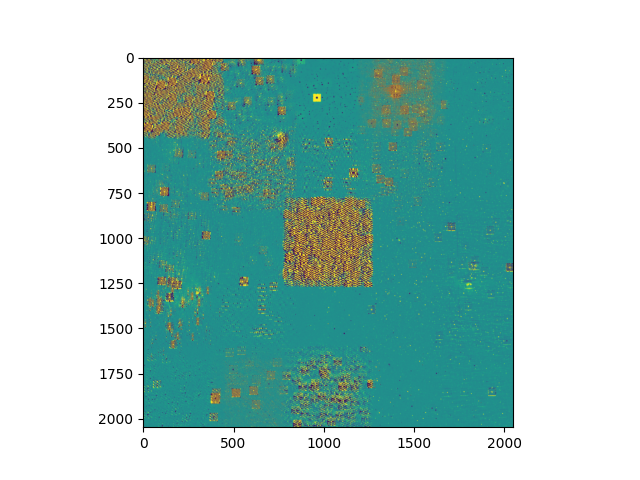

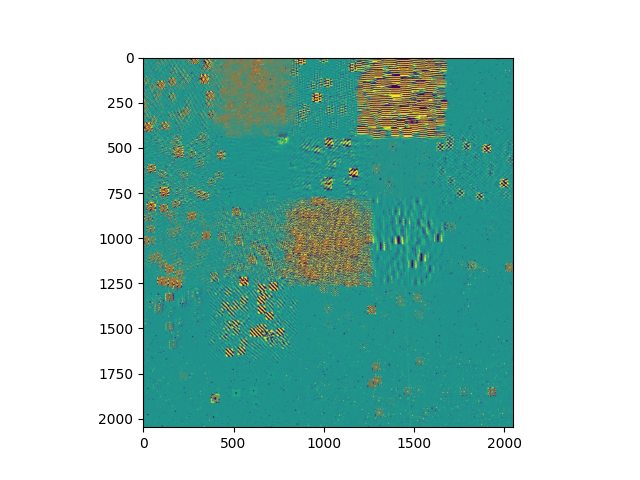

In [6]:

for i in range(len(diff_imgs)):
    data = diff_imgs[i]
    plt.figure()
    plt.imshow(data, vmin = np.nanpercentile(data, 5), vmax = np.nanpercentile(data, 95))
    plt.show()

In [ ]:
meta